In [2]:
%matplotlib notebook
import sys
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

In [3]:
Pixels = 256 # Cantidad de Píxeles del Detector.
N_Raws = 4 # Cantidad de imágenes a analizar.
N_Dopple = 2 # El archivo .raw genera dos imágenes, este número indica eso para promediarlas.
path= "C:\\Users\\Thomas\\XPCi_Project_Code\\Image_Reading\\RAWs\\Frame" # Directorio donde están los Raw.
path_txt = "C:\\Users\\Thomas\\XPCi_Project_Code\\Image_Reading\\Txts\\" # Directorio donde se ponen los Txt.

In [4]:
Step = "27.5" # Dato de geometry_config.in
Name_Used = "Trial"

In [5]:
"""
/// Generación de las imágenes a partir de los archivos .raw.
"""

def Matrix_Creator(Raw, Pixels):
    """
    Esta función genera una lista con un par de matrices que representan las dos imágenes que surgen al
    analizar el archivo .raw.
    """
    image_pair = []
    for k in range(0, len(Raw), Pixels*Pixels):
        blank = np.zeros((Pixels, Pixels))
        for i in range(Pixels):
            for j in range(Pixels):
                blank[i, j] = Raw[j + Pixels*i + k]
        image_pair.append(blank)
    return image_pair

def Data_Import(name, Pixels, NRaw):
    """
    Esta función se encarga de tomar la información de la ubicación de la carpeta con los archivos .raw
    y crear las matrices de números asociadas a cada una de las tomas de datos.
    
    Inputs:
        path: Directorio de la carpeta donde están los .raw.
        Pixels: Cantidad de píxeles de la matriz del detector.
        NRaw: Cantidad de imágenes .raw a analizar.
    
    Output:
        data: Lista con los pares de matrices de intensidad de cada .raw.
    """
    data = []
    
    if NRaw == 1:
            Raw = np.fromfile("C:\\Users\\Thomas\\XPCi_Project_Code\\Image_Reading\\RAWs\\{}".format(Name_Used) + ".raw", dtype='float32')
            matrix = Matrix_Creator(Raw, Pixels)
            data.append(matrix)
    else:
        for i in range(1, NRaw + 1):
            Raw = np.fromfile(name + "{}".format(i) + ".raw", dtype='float32')
            matrix = Matrix_Creator(Raw, Pixels)
            data.append(matrix)
    try:
        Raw_ = np.fromfile(name + "FF".format(i) + ".raw", dtype='float32')
        matrix_ = Matrix_Creator(Raw_, Pixels)
        data.append(matrix_)
    except IndexError:
        None
        
    return data

def Image_Generator(data, N_images, N_Dopple):
    """
    Esta función genera una lista con las matrices asociadas a cada imágen tomada. Se hace promediando
    las dos matrices de cada .raw para tener la intensidad media.
    
    Inputs:
        data: Lista con cada par de matrices asociado a los .raw que se analizaron.
        N_images: Cantidad de imágenes que se generarán.
        N_Dopple: Cantidad de imágenes por archivo .raw (no sabemos si varía).
    
    Output:
        images: Lista con las matrices asociadas a cada imagen analizada.
    """
    images = [] 
    for i in range(0, N_images):
        mean = (data[i][0] + data[i][1])/2
        images.append(mean)
    if len(data) > N_images:
        mean = (data[N_images][0] + data[N_images][1])/2
        images.append(mean)
    return images

"""
/// Creación de los histogramas de comparación entre píxeles pares e impares.
"""

def Intensity_Mean(image, Pixels):
    intensity = np.zeros(Pixels)
    normalizer = 0
    for i in range(0, Pixels):
        intensity += image[i, 0:Pixels]
        candidate = np.sum(image[i, 0:Pixels])
        if candidate > normalizer:
            normalizer = candidate
    mean = intensity/normalizer
    return mean

def Aver(name,X1,X2,Step):
    P=np.copy(name)
    for i in range(len(P)):
        P[i,X1:X2]=(1/2)*(P[i,X1-Step:X2-Step]+P[i,X1+Step:X2+Step])
    return P

In [6]:
brute_material = Data_Import(path, Pixels, N_Raws)
images = Image_Generator(brute_material, N_Raws, N_Dopple)
for i in range(1, N_Raws + 1):
    try:
        np.savetxt(path_txt + "Frame{}.txt".format(i), images[i - 1])
    except IndexError:
        np.savetxt(path_txt + "{}.txt".format(Name_Used), images[0])
        break
        
if len(brute_material) > N_Raws:
    np.savetxt(path_txt + "FrameFF.txt", images[N_Raws])

<IPython.core.display.Javascript object>


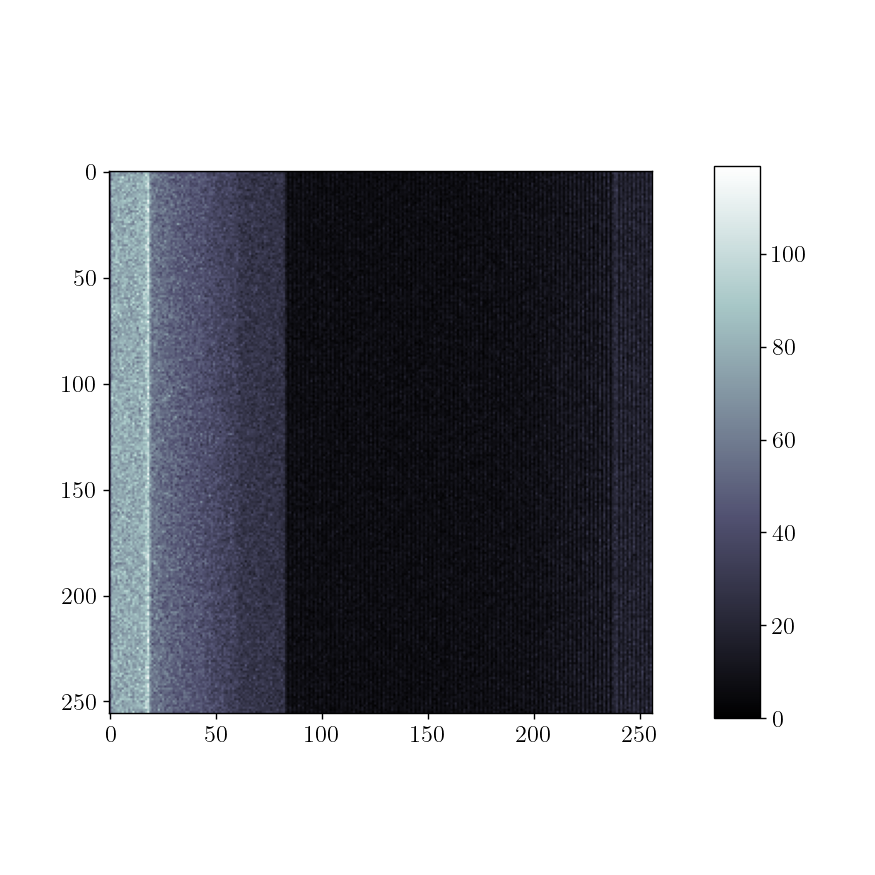

In [11]:
k = 1
fig, ax = plt.subplots(figsize=(7, 7))
u=ax.imshow(images[k], cmap = "bone")
fig.colorbar(u,ax=ax,location='right', anchor=(0.5, 0.5), shrink=0.82,aspect=12)

<IPython.core.display.Javascript object>


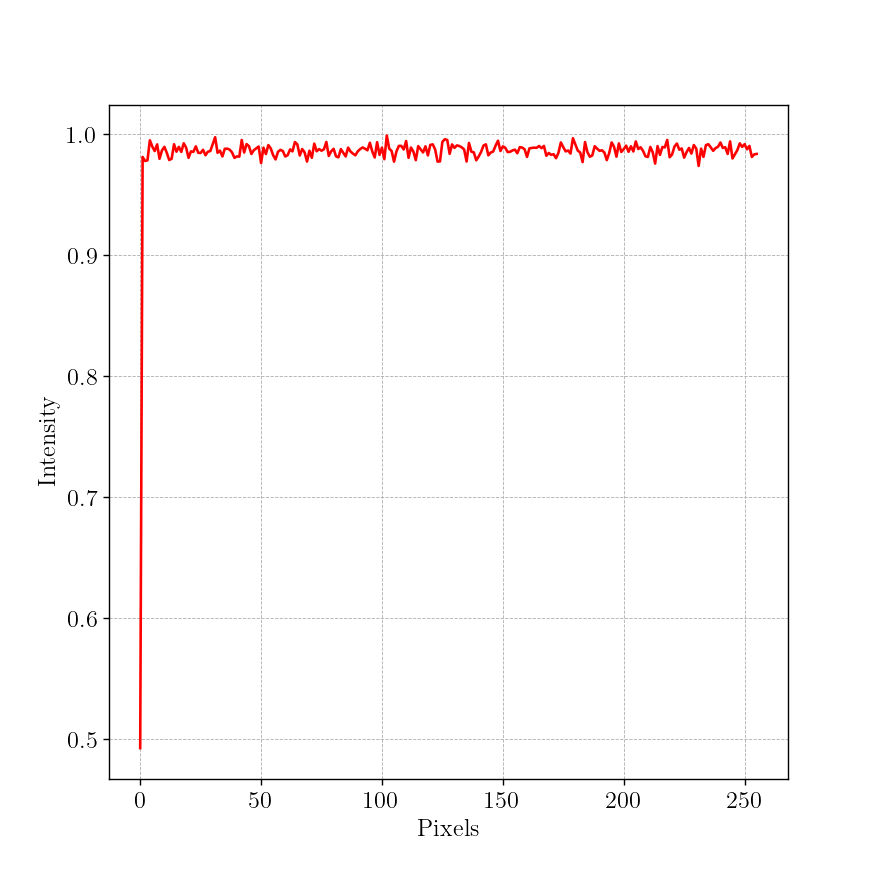

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = Intensity_Mean(images[k], Pixels)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels",fontsize=14)
ax.set_ylabel("Intensity",fontsize=14)
ax.grid(linestyle = '--', linewidth = 0.5)

<IPython.core.display.Javascript object>


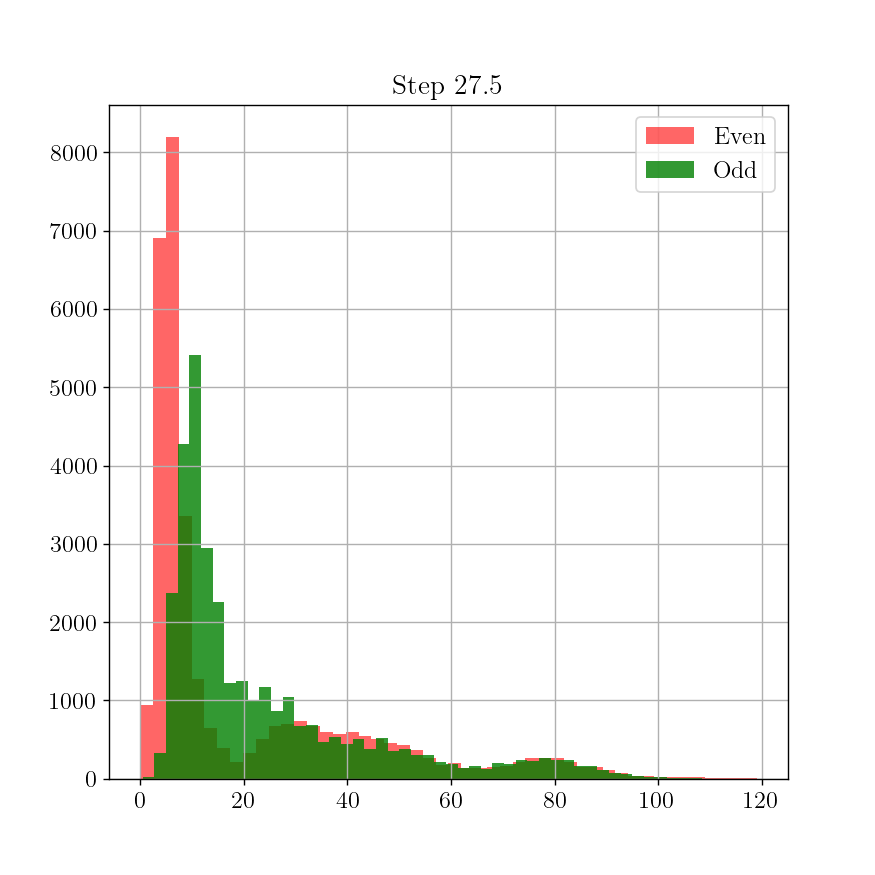

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(True)
even_pixels = images[k][:,::2]
odd_pixels = images[k][:,1::2]

bin_size = 48
GNMe =ax.hist(np.ravel(even_pixels),bins = bin_size, color="red", label="Even", alpha=0.6)
GNMo =ax.hist(np.ravel(odd_pixels),bins = bin_size, color="green", label="Odd", alpha=0.8)
ax.set_title("Step {}".format(Step), fontsize=16)
ax.legend()

In [13]:
# Cargar los datos desde los archivos TXT
for i in range(1, N_Raws + 1):
    try:
        Frame = np.loadtxt(path_txt + "Frame{}.txt".format(i))  # Cargar la primera imagen
        FrameFF = np.loadtxt(path_txt + "FrameFF.txt")  # Cargar la imagen de fondo o referencia
    except Exception as e:
        print(f"Error al cargar los archivos: {e}")
        sys.exit()


    # Verificar que ambas matrices tengan las mismas dimensiones
    if Frame.shape != FrameFF.shape:
        print("Error: Las dimensiones de Frame{}.txt y FrameFF.txt no coinciden.".format(i))
        sys.exit()


    # Realizar la división evitando división por cero
    raw = np.divide(Frame, FrameFF, out = np.zeros_like(Frame), where = FrameFF != 0)

    # Guardar el resultado en un nuevo archivo de texto
    np.savetxt(path_txt + "Norm\\Frame_{}.txt".format(i), raw, fmt="%.6f")  # Guarda con 6 decimales de precisión